# Desafio

Seu objetivo é identificar quais máquinas apresentam potencial de falha tendo como base dados extraídos através de sensores durante o processo de manufatura.  Para isso são fornecidos dois datasets: um dataset chamado desafio_manutencao_preditiva_treino composto por 6667 linhas, 9 colunas de informação (features) e a variável a ser prevista (“failure_type”).

Participante: Victor Afonso Bauler

# Sumário Executivo



# Solução

## 1 - Importando bibliotecas necessárias

Esta etapa consiste em importar as bibliotecas utilizadas no projeto.

In [116]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

from sklearn.exceptions import ConvergenceWarning
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, precision_score, accuracy_score, roc_curve, confusion_matrix

from xgboost import XGBClassifier

## 2 - Carregamentos dos dados e checagem preliminar

Durante esta etapa é realizada a leitura dos datasets fornecidos e checagem de valores faltantes e duplicados, buscando verificar se existe algum tipo de problema nos dados fornecidos.

In [21]:
# Definindo o diretório raiz
ROOT_DIR = os.path.dirname(os.path.abspath(''))

# Carregando os dados
df_train = pd.read_csv(f'{ROOT_DIR}/data/desafio_manutencao_preditiva_treino.csv')
df_test = pd.read_csv(f'{ROOT_DIR}/data/desafio_manutencao_preditiva_teste.csv')

# Verificando a quantidade de linhas e colunas
print(df_train.shape, df_test.shape)

(6667, 9) (3333, 8)


In [40]:
# Analisando dados faltantes
print(f"Dados faltantes no dataset de treino \n{df_train.isna().sum()}\n")
print(f"Dados faltantes no dataset de teste \n{df_test.isna().sum()}")

Dados faltantes no dataset de treino 
udi                      0
product_id               0
type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
failure_type             0
dtype: int64

Dados faltantes no dataset de teste 
udi                      0
product_id               0
type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
dtype: int64


In [43]:
# Analisando dados duplicados
print(f"Dados duplicados no dataset de treino \n{df_train.duplicated().sum()}\n")
print(f"Dados duplicados no dataset de teste \n{df_test.duplicated().sum()}")

Dados duplicados no dataset de treino 
0

Dados duplicados no dataset de teste 
0


## 3 - Análise Exploratória

Durante esta etapa, o objetivo é entender melhor o conjunto de dados que estamos trabalhando. É importante lembrar que essa análise deve ser realizada apenas com o conjunto de dados de treinamento, pois é nele que vamos encontrar as tendências e relações que serão utilizadas para treinar nosso modelo. Analisar o conjunto de dados de teste pode levar a vieses e distorções na análise, pois esses dados devem ser reservados para avaliar a performance do modelo treinado. Isso inclui verificar as características dos dados, como o número de amostras, atributos e tipos de dados, bem como identificar possíveis problemas como valores ausentes ou outliers. Para realização desta análise, serão utilizadas bibliotecas de visualização de dados e estatísticas descritivas.

As colunas udi e product ID serão deixadas de lado nessa etapa.

### a) Estatísticas Descritivas

#### i) Variáveis numéricas

In [61]:
numerical_features = df_train.select_dtypes(include=['int64', 'float64']).columns
numerical_features = numerical_features.drop('udi')

# Estatísticas descritivas das variáveis numéricas
df_train[numerical_features].describe()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
count,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000
mean,299.992515,309.992620,1537.419529,40.058512,108.098095
std,1.994710,1.488101,177.182908,9.950804,63.359915
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1422.500000,33.200000,54.000000
50%,300.000000,310.000000,1503.000000,40.200000,108.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.600000,251.000000


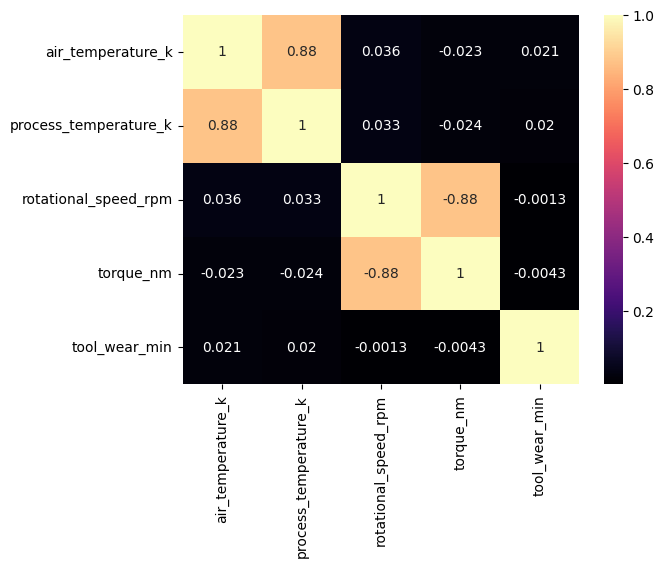

In [62]:
# Correlação entre as variáveis numéricas
corr = df_train[numerical_features].corr(numeric_only=True)
sns.heatmap(corr.abs(), annot=corr, cmap='magma');

#### ii) Variáveis categóricas

In [65]:
categorical_features = df_train.select_dtypes(include=['object']).columns
categorical_features = categorical_features.drop('product_id')

# Estatísticas descritivas das variáveis categóricas
df_train[categorical_features].describe()

,type,failure_type
count,6667,6667
unique,3,6
top,L,No Failure
freq,4022,6435


É possível notar que o dataset é extremamente desbalanceado de forma que 96,5% dos dados são rotulados sem defeito, sendo assim, na parte de modelagem será necessário aplicar métricas de avaliação que suportam esse tipo de problema, como score F1 e acurácia balanceada. 

### b) Plots de distribuições com varíavel de saída

#### i) Variáveis numéricas

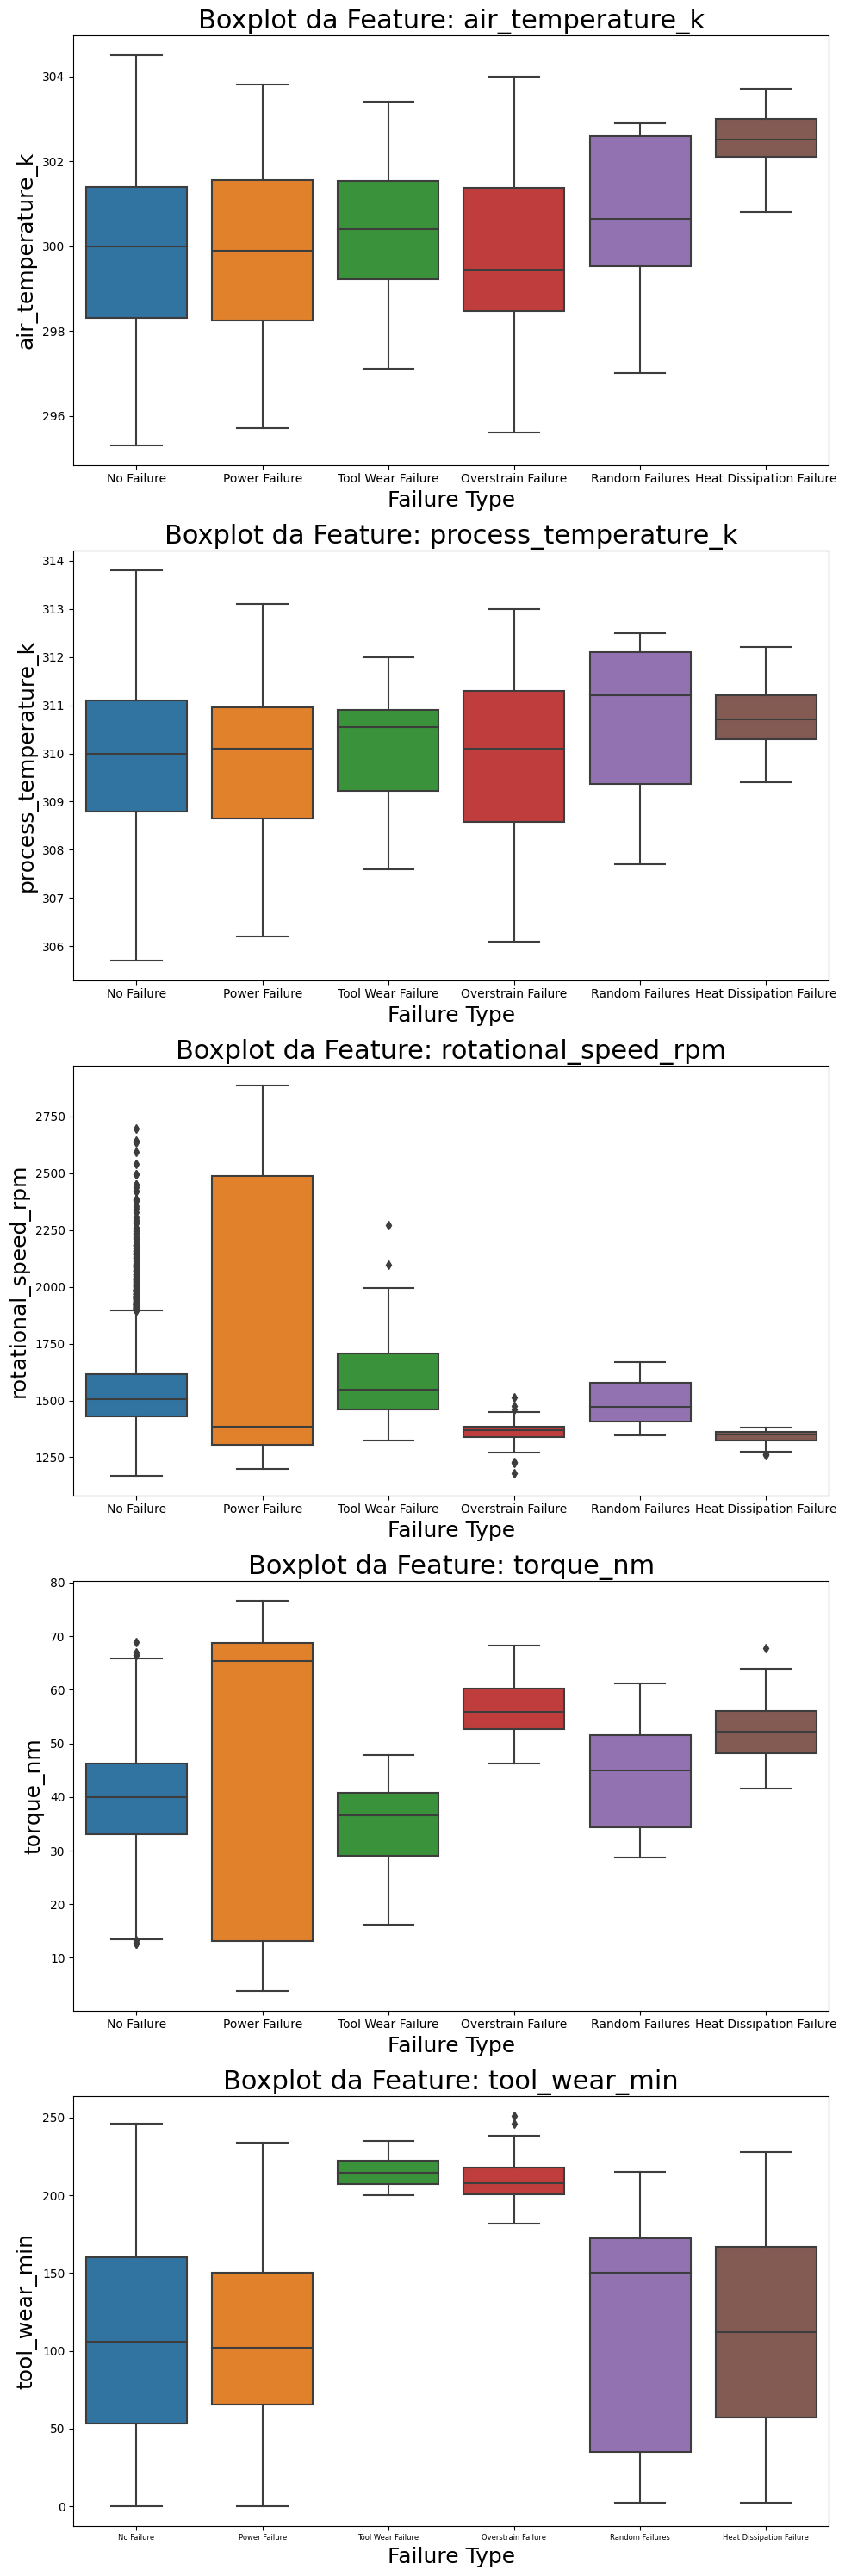

In [86]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 30))

for i, column in enumerate(numerical_features):
    ax = sns.boxplot(data=df_train, y=column, x='failure_type', ax=axes[i])
    ax.set_title(f'Boxplot da Feature: {column}', fontsize=22)
    ax.set_ylabel(column, fontsize=18)
    ax.set_xlabel('Failure Type', fontsize=18)
    plt.xticks(fontsize=6)
    
plt.tight_layout()
plt.show()

#### ii) Variáveis categóricas

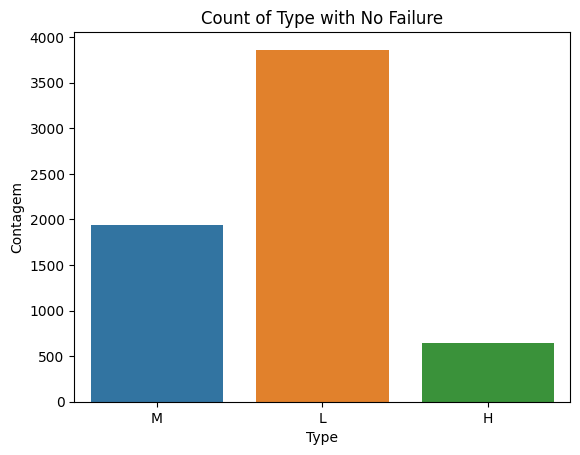

In [95]:
# Desenha o gráfico de barras agrupadas
sns.countplot(x='type', data=df_train[categorical_features][df_train['failure_type'] == 'No Failure'])

# Adiciona título, rótulos de eixos e legenda
plt.title('Count of Type with No Failure')
plt.xlabel('Type')
plt.ylabel('Contagem')

# Exibe o gráfico
plt.show()

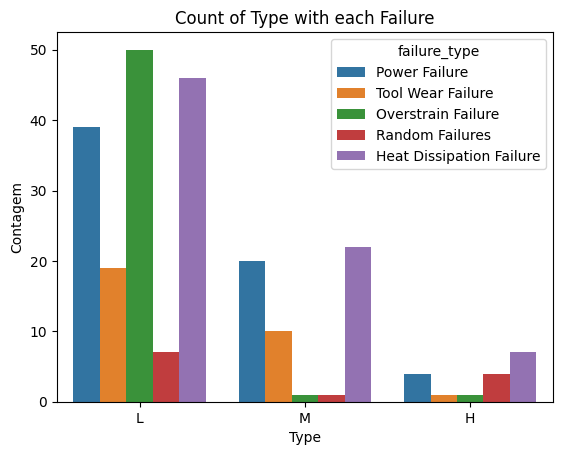

In [94]:
# Cria um gráfico de barras agrupadas
sns.countplot(x='type', hue='failure_type', data=df_train[categorical_features][df_train['failure_type'] != 'No Failure'])

# Adiciona título e rótulos de eixos
plt.title('Count of Type with each Failure')
plt.xlabel('Type')
plt.ylabel('Contagem')

# Exibe o gráfico
plt.show()

## 4 - Modelos

Aqui serão desenvolvidas as pipelines para treinamento dos modelos, serão avaliados 3 modelos diferentes (LogisticRegression, RandomForest e XGBoost).
Para a otimização de hiperparâmetros será utilizada a função GridSearchCV do Scikit-learn que avalia o resultado para cada combinação de hiperparâmetros fornecida, utilizando uma validação cruzada de 5 folds (tais decisões foram tomadas tendo em vista que o dataset não é tão grande, e o custo computacional para tal não será muito alto).

In [99]:
X_train = df_train.drop(['failure_type', 'product_id', 'udi'], axis=1)
y_train = df_train['failure_type']

X_test = df_test.drop(['product_id', 'udi'], axis=1)


In [115]:
def create_pipeline(clf):
    """Cria a pipeline de pré-processamento do classificador com OneHotEncoder nas features categoricas

    Parameters
    ----------
    clf : estimator object
        Classificador que será utilizado na pipeline

    Returns
    -------
    pipe : Pipeline
        Pipeline de pré-processamento
    """

    categorical_selector = make_column_selector(dtype_exclude=np.number)

    encode_categorical = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), categorical_selector),
    remainder="passthrough"
    )
    
    pipe = make_pipeline(encode_categorical,
                         clf)
    return pipe


def perform_grid_search(pipe, param_grid, X_train, y_train):
    """Realiza o GridSearchCV usando a pipeline e os parâmetros fornecidos

    Parameters
    ----------
    pipe : Pipeline
        Pipeline de pré-processamento
    param_grid : dict
        Dicionário de parâmetros para a busca
    X_train : array-like ou pd.DataFrame
        Features de treinamento
    y_train : array-like
        Variável alvo de treinamento

    Returns
    -------
    gs : GridSearchCV
        Objeto GridSearchCV treinado
    """

    gs = GridSearchCV(
        pipe,
        param_grid,
        cv=5,
        scoring=['f1_weighted', 'roc_auc_ovr'],
        return_train_score=True,
        refit='f1_weighted'
    )
    gs.fit(X_train, y_train)

    return gs


def display_results(gs, param_grid):
    """Processa os resultados da busca e exibe os 10 melhores resultados a partir da métrica de validação (acurácia balanceada)
    
    Parameters
    ----------
    gs : GridSearchCV
        Objeto GridSearchCV treinado
    param_grid : dict
        Dicionário de parâmetros para a busca
    """
    df = pd.DataFrame(gs.cv_results_)

    params = []
    for param in param_grid:
        param_name = param.split('__')[1]
        param_name = param_name.replace('_', ' ')
        param_name = param_name.title()
        params.append(param_name)
        df.rename(columns={f'param_{param}': param_name}, inplace=True)

    df.rename(columns={'mean_test_roc_auc_ovr': 'Mean Test Roc AUC Ovr',
                       'mean_train_roc_auc_ovr': 'Mean Train Roc AUC Ovr',
                       'mean_test_f1_weighted': 'Mean Test F1 Weighted'}, inplace=True)

    df = df[['Mean Test Roc AUC Ovr', 'Mean Train Roc AUC Ovr', 'Mean Test F1 Weighted'] + params]

    display(df.sort_values(by='Mean Test F1 Weighted', ascending=False).head(10))


def model_tuning(clf, param_grid, X_train, y_train):
    """Realiza o GridSearchCV usando o classificador e os parâmetros fornecidos

    Parameters
    ----------
    clf : estimator object
        Classificador que será utilizado no GridSearchCV
    param_grid : dict
        Dicionário de parâmetros para a busca
    X_train : array-like ou pd.DataFrame
        Features de treinamento
    y_train : array-like
        Variável alvo de treinamento

    Returns
    -------
    gs : GridSearchCV
        Objeto GridSearchCV treinado
    """
    pipe = create_pipeline(clf)
    gs = perform_grid_search(pipe, param_grid, X_train, y_train)
    display_results(gs, param_grid)

    return gs

### a) LogisticRegression

In [119]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
    clf_logistic = LogisticRegression(random_state=42, solver='liblinear')

    param_grid_logistic = {
        'logisticregression__C': np.logspace(-3, 3, 10),
        'logisticregression__penalty': ['l1', 'l2']
    }

    gs_logistic = model_tuning(clf_logistic, param_grid_logistic, X_train, y_train)

,Mean Test Roc AUC Ovr,Mean Train Roc AUC Ovr,Mean Test F1 Weighted,C,Penalty
9,0.928577,0.947873,0.965829,0.464159,l2
11,0.934498,0.950761,0.964685,2.154435,l2
14,0.930859,0.944400,0.964375,46.415888,l1
7,0.915745,0.934921,0.964333,0.1,l2
18,0.934732,0.946943,0.964322,1000.0,l1
16,0.933198,0.945967,0.964002,215.443469,l1
12,0.931054,0.943715,0.963922,10.0,l1
10,0.930910,0.943972,0.963551,2.154435,l1
8,0.898158,0.922783,0.963360,0.464159,l1
5,0.908682,0.924822,0.962649,0.021544,l2


### b) RandomForest

In [ ]:
clf_random_forest = RandomForestClassifier(random_state=42)

param_grid_random_forest = {
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [5, 10, 15],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    

### XGBoost

## 5 - Conclusão